# Face Mask Detection using CNN (Yolo v11)

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammawahaj","key":"e3c5851ce6e218da454d3bdde71a8dff"}'}

In [2]:
import os
import zipfile
# Make kaggle directory and move the json
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# **Traffic Sign Classification Using Custom CNN**
# Replace this with the Kaggle dataset identifier from the URL
DATASET_PATH = "andrewmvd/face-mask-detection"

# Output folder in your Drive
OUTPUT_DIR = "/content/drive/MyDrive/FaceMaskKaggleDataset"

# Download and unzip
!kaggle datasets download -d {DATASET_PATH} -p {OUTPUT_DIR}
!unzip -q "{OUTPUT_DIR}/*.zip" -d {OUTPUT_DIR}


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
 93% 369M/398M [00:02<00:00, 110MB/s] 
100% 398M/398M [00:02<00:00, 143MB/s]


In [21]:
!pip install ultralytics

In [2]:
# Python librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

# Data Conversion: XML files to Yolo .txt label files

In [3]:
# Preparing Data For Model(YoloV11)
# I will use these functions for .xml to .txt format.
def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    w_half_len = (bbox[2] + w) / 2
    h_half_len = (bbox[3] + h) / 2

    xmin = int((bbox[0] + w) - w_half_len)
    ymin = int((bbox[1] + h) - h_half_len)
    xmax = int((bbox[0] + w) + w_half_len)
    ymax = int((bbox[1] + h) + h_half_len)

    return[xmin, ymin, xmax, ymax]
# Conversion phase
classes = []

input_dir = '/content/drive/MyDrive/FaceMaskKaggleDataset/annotations'
output_dir = '/content/drive/MyDrive/FaceMaskKaggleDataset/labels'
image_dir = '/content/drive/MyDrive/FaceMaskKaggleDataset/images'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

files = glob.glob(os.path.join(input_dir, '*.xml'))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f'{filename}.png')):
        print(f'{filename} image does not exist')
        continue

    result = []

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text

        if label not in classes:
            classes.append(label)

        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        bbox_string =  ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')

    if result:
        with open(os.path.join(output_dir, f'{filename}.txt'), 'w', encoding = 'utf-8') as f:
            f.write('\n'.join(result))

with open(f'{output_dir}/classes.txt', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(classes))

In [4]:
annotation_count = len(os.listdir("/content/drive/MyDrive/FaceMaskKaggleDataset/annotations"))
labels_count = len(os.listdir("/content/drive/MyDrive/FaceMaskKaggleDataset/labels"))
print(f"Annotation Counts: {annotation_count}")
print(f"Lables Counts: {labels_count}")

Annotation Counts: 853
Lables Counts: 854


In [5]:
import os

base_path = "/content/drive/MyDrive/kaggle/working/data"

if not os.path.exists(base_path):
    os.makedirs(base_path + "/train/images")
    os.makedirs(base_path + "/train/labels")
    os.makedirs(base_path + "/val/images")
    os.makedirs(base_path + "/val/labels")
    os.makedirs(base_path + "/test/images")
    os.makedirs(base_path + "/test/labels")


In [6]:
# Material is the names of images in the images folder.
metarial = []
for i in os.listdir("/content/drive/MyDrive/FaceMaskKaggleDataset/images"):
    str = i[:-4]
    metarial.append(str)
metarial[0:3]

['maksssksksss605', 'maksssksksss669', 'maksssksksss671']

In [7]:
print("Sum of image: ", len(metarial))
train_size = int(len(metarial) * 0.7)
test_size = int(len(metarial) * 0.15)
val_size = int(len(metarial) * 0.15)
print("Sum of the train size: ", train_size)
print("Sum of the test size: ", test_size)
print("Sum of the val size: ", val_size)

Sum of image:  853
Sum of the train size:  597
Sum of the test size:  127
Sum of the val size:  127


In [18]:
import os
import random
import shutil

# Paths
base_path = "/content/drive/MyDrive/kaggle/working/data"
images_path = "/content/drive/MyDrive/FaceMaskKaggleDataset/images"
labels_path = "/content/drive/MyDrive/FaceMaskKaggleDataset/labels"

# Output folders
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(f"{base_path}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_path}/{split}/labels", exist_ok=True)

# Parameters
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Get all images
all_images = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(all_images)

# Split data
train_end = int(len(all_images) * train_split)
val_end = train_end + int(len(all_images) * val_split)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

splits_dict = {"train": train_files, "val": val_files, "test": test_files}

# Copy files
for split, files in splits_dict.items():
    for img_file in files:
        # image path
        src_img = os.path.join(images_path, img_file)
        dst_img = os.path.join(base_path, split, "images", img_file)

        # label path (same name but .txt extension)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        src_lbl = os.path.join(labels_path, label_file)
        dst_lbl = os.path.join(base_path, split, "labels", label_file)

        # copy only if label exists
        if os.path.exists(src_lbl):
            shutil.copy(src_img, dst_img)
            shutil.copy(src_lbl, dst_lbl)


# Model Training

In [19]:
# Create the data.yaml for YOLO training
yaml_text = """train: /content/drive/MyDrive/kaggle/working/data/train/images
val: /content/drive/MyDrive/kaggle/working/data/val/images

nc: 3
names: ["with_mask", "mask_weared_incorrect", "without_mask"]"""

with open("/content/drive/MyDrive/kaggle/working/data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [22]:
# We should close wandb because If we don't close wandb we can't start training.
import wandb
wandb.init(mode='disabled')

In [24]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')
results = model.train(data="/content/drive/MyDrive/kaggle/working/data/data.yaml", epochs=50, imgsz=640, save = True, device = [0])

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/kaggle/working/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 23        [16, 19, 22]  1    431257  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.2 ms, read: 127.3±75.3 MB/s, size: 554.7 KB)


train: Scanning /content/drive/MyDrive/kaggle/working/data/train/labels... 597 images, 0 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:05<00:00, 109.27it/s]


train: New cache created: /content/drive/MyDrive/kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 5.0±5.9 ms, read: 101.1±94.1 MB/s, size: 424.9 KB)


val: Scanning /content/drive/MyDrive/kaggle/working/data/val/labels... 170 images, 0 backgrounds, 0 corrupt: 100%|██████████| 170/170 [00:01<00:00, 104.80it/s]


val: New cache created: /content/drive/MyDrive/kaggle/working/data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.54G       1.75      2.999      1.383         39        640: 100%|██████████| 38/38 [00:23<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all        170        849     0.0124      0.536      0.247      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.52G      1.421      1.581      1.061         35        640: 100%|██████████| 38/38 [00:19<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        170        849      0.902      0.165      0.259      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.53G      1.312       1.35      1.061         85        640: 100%|██████████| 38/38 [00:17<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        170        849      0.716      0.283      0.343       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.56G      1.265      1.225      1.047         50        640: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        170        849      0.489       0.46      0.506      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.56G      1.256      1.149      1.044         63        640: 100%|██████████| 38/38 [00:17<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        170        849      0.532      0.468      0.518      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.59G      1.208      1.093      1.028         37        640: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        170        849      0.932      0.458      0.544      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       3.6G      1.215       1.03      1.026         16        640: 100%|██████████| 38/38 [00:18<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        170        849      0.624      0.529      0.578      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.62G       1.19     0.9524      1.007         39        640: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


                   all        170        849      0.655      0.561       0.61      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.62G       1.16     0.9441      1.021         33        640: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        170        849       0.62      0.582      0.606      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.64G      1.182     0.9517      1.022         37        640: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


                   all        170        849       0.77      0.595      0.642      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.65G      1.126     0.8786      1.008         42        640: 100%|██████████| 38/38 [00:17<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


                   all        170        849      0.744      0.613       0.67      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.67G       1.16     0.8776      1.006         45        640: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        170        849      0.786      0.584      0.644      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.68G      1.131     0.8496     0.9933         46        640: 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        170        849      0.755      0.625      0.685      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.7G      1.119     0.7839     0.9831         35        640: 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


                   all        170        849      0.792      0.629      0.715       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.71G      1.101     0.7758     0.9911         22        640: 100%|██████████| 38/38 [00:17<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        170        849      0.827      0.632      0.732       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.73G      1.103     0.7767     0.9944         25        640: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]

                   all        170        849      0.905      0.634      0.737      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.74G      1.114     0.7533     0.9872         30        640: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        170        849      0.824      0.627      0.725       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.76G      1.098      0.759     0.9824         44        640: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

                   all        170        849      0.777       0.62       0.71      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.77G      1.092     0.7387     0.9771         38        640: 100%|██████████| 38/38 [00:18<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        170        849      0.678       0.68      0.721      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.79G      1.063     0.7322      0.974         34        640: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        170        849      0.743      0.703      0.754      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.8G      1.065     0.7063     0.9798         36        640: 100%|██████████| 38/38 [00:18<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


                   all        170        849      0.743      0.676      0.713       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.82G      1.086     0.6944     0.9743         47        640: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

                   all        170        849      0.882      0.614      0.751      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.83G       1.09     0.7197     0.9699         37        640: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        170        849       0.92       0.68      0.767      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.85G      1.062     0.6832     0.9668         91        640: 100%|██████████| 38/38 [00:19<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        170        849      0.869      0.644      0.743      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.86G       1.04     0.6627     0.9621         41        640: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        170        849      0.744      0.748      0.774      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.88G      1.047     0.6546     0.9652         41        640: 100%|██████████| 38/38 [00:19<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        170        849      0.857      0.716       0.79      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.89G      1.045     0.6608     0.9598         44        640: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

                   all        170        849      0.879      0.687      0.801      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.91G      1.017     0.6278      0.953         56        640: 100%|██████████| 38/38 [00:17<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        170        849      0.739      0.721      0.773      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.92G      1.045     0.6439     0.9566         41        640: 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        170        849      0.848      0.722      0.797      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.94G      1.004     0.6215     0.9526         17        640: 100%|██████████| 38/38 [00:17<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        170        849      0.863      0.688      0.785      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.95G      1.031     0.6166     0.9506         65        640: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        170        849      0.846      0.706      0.791      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.97G      1.024     0.6194     0.9525         32        640: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

                   all        170        849      0.938      0.697      0.789      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.98G     0.9758     0.5943     0.9451         47        640: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

                   all        170        849      0.842      0.701      0.777      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         4G     0.9965       0.59     0.9513         41        640: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


                   all        170        849      0.915      0.729      0.816      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.01G     0.9982     0.5849     0.9466         21        640: 100%|██████████| 38/38 [00:18<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        170        849      0.848      0.717      0.796       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.03G     0.9892     0.5847      0.931         44        640: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        170        849      0.827      0.703      0.789      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.04G     0.9734     0.5723     0.9373         62        640: 100%|██████████| 38/38 [00:19<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        170        849      0.837      0.743      0.807      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.06G     0.9751     0.5776     0.9442         22        640: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        170        849      0.911      0.695      0.815      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.07G     0.9748     0.5659     0.9389         48        640: 100%|██████████| 38/38 [00:18<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        170        849       0.89      0.711       0.82      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.09G     0.9631     0.5506     0.9381         19        640: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        170        849      0.925      0.715      0.813      0.541


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       4.1G      0.936     0.5606     0.9272         13        640: 100%|██████████| 38/38 [00:20<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


                   all        170        849       0.88      0.681      0.799      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.12G      0.938     0.5427      0.924          7        640: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

                   all        170        849      0.864      0.721      0.796      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.13G      0.937      0.528     0.9199         27        640: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        170        849      0.942       0.71      0.824      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.15G     0.9217     0.5073     0.9199         10        640: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        170        849      0.894      0.738      0.819      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.15G     0.9298     0.5133     0.9192         25        640: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        170        849      0.893      0.704      0.813      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.18G     0.9118     0.5014     0.9143         22        640: 100%|██████████| 38/38 [00:16<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

                   all        170        849      0.916      0.712      0.825      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.19G     0.8964     0.4855     0.9111         18        640: 100%|██████████| 38/38 [00:17<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

                   all        170        849      0.926      0.727      0.824      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.21G     0.8932     0.4913     0.9063         28        640: 100%|██████████| 38/38 [00:17<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        170        849      0.943      0.701      0.817      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.22G     0.8871     0.4819     0.9087         11        640: 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        170        849      0.866      0.755       0.83      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.24G     0.8836     0.4766     0.9075         27        640: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        170        849       0.85      0.774      0.827      0.564



50 epochs completed in 0.311 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


                   all        170        849      0.866      0.755      0.829      0.564
             with_mask        153        654      0.928      0.875      0.941      0.641
 mask_weared_incorrect         58        171      0.896      0.766      0.863      0.545
          without_mask         19         24      0.773      0.625      0.682      0.507
Speed: 0.8ms preprocess, 4.8ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to runs/detect/train


# Model Testing

In [26]:
model_predict = YOLO("/content/runs/detect/train/weights/best.pt")

In [31]:
model_predict.predict("/content/drive/MyDrive/kaggle/working/data/test/images/maksssksksss636.png", save=True)


image 1/1 /content/drive/MyDrive/kaggle/working/data/test/images/maksssksksss636.png: 480x640 6 with_masks, 2 mask_weared_incorrects, 91.5ms
Speed: 4.6ms preprocess, 91.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
 obb: None
 orig_img: array([[[ 66,  65, 124],
         [ 47,  46, 115],
         [ 45,  45, 124],
         ...,
         [ 47,  43, 149],
         [ 42,  41, 158],
         [ 50,  52, 165]],
 
        [[ 70,  66, 149],
         [ 47,  46, 134],
         [ 37,  37, 129],
         ...,
         [ 42,  38, 146],
         [ 37,  36, 155],
         [ 45,  47, 163]],
 
        [[ 64,  54, 141],
         [ 46,  41, 127],
         [ 39,  35, 121],
         ...,
         [ 45,  40, 149],
         [ 38,  38, 159],
         [ 47,  48, 166]],
 
        ...,
 
        [[ 57,  72,  88],
         [ 53,  65,  82],
         [ 54,  64,  81],
         ...,
         [116, 116, 112],
         [141, 141, 138],
         [163, 164, 160]],
 
        [[ 60,  75,  90],
         [ 57,  69,  85],
        

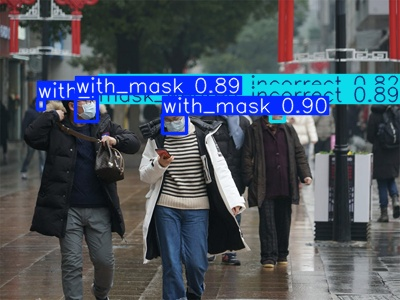

In [32]:
Image.open("/content/runs/detect/predict/maksssksksss636.jpg")

In [34]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Input video path
input_video = "/content/stock-footage-multi-ethnic-passengers-in-tram-wearing-protective-face-masks-diverse-people-travel-on-public.webm"  # or upload a video

# Run prediction on the video and save output
results = model.predict(
    source=input_video,      # video file
    save=True,               # save a single output video with boxes & labels
    conf=0.25,               # confidence threshold
    project="/content/drive/MyDrive/kaggle/working/runs/detect",
    name="video_output"      # output folder
)

print("✅ Output video saved in:")
print("/content/drive/MyDrive/kaggle/working/runs/detect/video_output/")



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/315) /content/stock-footage-multi-ethnic-passengers-in-tram-wearing-protective-face-masks-diverse-people-travel-on-public.webm: 384x640 7 with_masks, 67.2ms
video 1/1 (frame 2/315) /content/stock-footage-multi-ethnic-passengers-in-tram-wearing-protective-face-masks-diverse-people-travel-on-public.webm: 384x640 7 with_masks, 13.7ms
video 1/1 (frame 3/315) /content/stock-footage-multi-ethnic-passengers-in-tram-wearing-protective-face-m